In [10]:
import pandas as pd
import numpy as np 
import statsmodels.api as sm
from scipy.optimize import minimize_scalar
import support_functions as sf
import importlib, support_functions, inspect
importlib.reload(support_functions)
# print('module file:', support_functions.__file__)
# print(inspect.getsource(support_functions.change_product_name)[:400])
# from pygam import glm, s, f, te, PoissonGAM, ExponentialGAM, ExpectileGAM
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

path = Path("data") / "ml_task_data.csv"
raw_data = pd.read_csv(path)
# raw_data.sample(3)

In [11]:
# Preprocess data
df = support_functions.create_date_time_index(raw_data)
# quick check of products
# df['product_id'].value_counts()

In [12]:
df = support_functions.change_product_name(df)
df['product_id'].value_counts()

product_id
product_A    755
product_B    739
product_C    737
product_D    677
product_E    645
Name: count, dtype: int64

In [13]:
df_product_A, df_product_B, df_product_C, df_product_D, df_product_E = support_functions.createProductDataFrames(df)  

In [14]:


from support_functions import change_column_names


df_product_A =change_column_names(df_product_A, 'A')
df_product_B =change_column_names(df_product_B, 'B')
df_product_C =change_column_names(df_product_C, 'C')
df_product_D =change_column_names(df_product_D, 'D')
df_product_E =change_column_names(df_product_E, 'E')
# Show the first rows and columns to confirm
df_product_A.head()


,sell_price_A,margin_A,sales_A,log_sell_price_A,log_sales_A
date,,,,,
2019-01-01,82.39,24.72,19,4.423528,2.995732
2019-01-02,82.39,24.72,41,4.423528,3.737670
2019-01-03,82.39,24.72,66,4.423528,4.204693
2019-01-04,82.39,24.72,77,4.423528,4.356709
2019-01-05,82.39,24.72,77,4.423528,4.356709


In [15]:
df_merge = df_product_A.merge(df_product_B, left_index=True, right_index=True, how='outer') \
              .merge(df_product_C, left_index=True, right_index=True, how='outer') \
                  .merge(df_product_D, left_index=True, right_index=True, how='outer') \
                      .merge(df_product_E, left_index=True, right_index=True, how='outer')
                      
df_merge.head()

,sell_price_A,margin_A,sales_A,log_sell_price_A,log_sales_A,sell_price_B,margin_B,sales_B,log_sell_price_B,log_sales_B,...,sell_price_D,margin_D,sales_D,log_sell_price_D,log_sales_D,sell_price_E,margin_E,sales_E,log_sell_price_E,log_sales_E
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,82.39,24.72,19.0,4.423528,2.995732,36.19,10.86,6.0,3.61604,1.945910,...,43.89,13.17,1.0,3.804215,0.693147,NaN,NaN,NaN,NaN,NaN
2019-01-02,82.39,24.72,41.0,4.423528,3.737670,36.19,10.86,23.0,3.61604,3.178054,...,43.89,13.17,2.0,3.804215,1.098612,NaN,NaN,NaN,NaN,NaN
2019-01-03,82.39,24.72,66.0,4.423528,4.204693,36.19,10.86,37.0,3.61604,3.637586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,82.39,24.72,77.0,4.423528,4.356709,36.19,10.86,21.0,3.61604,3.091042,...,43.89,13.17,5.0,3.804215,1.791759,NaN,NaN,NaN,NaN,NaN
2019-01-05,82.39,24.72,77.0,4.423528,4.356709,36.19,10.86,24.0,3.61604,3.218876,...,43.89,13.17,6.0,3.804215,1.945910,NaN,NaN,NaN,NaN,NaN


In [17]:
df_merge = sf.create_temporal_features(df_merge)
# df_merge.sample(10)

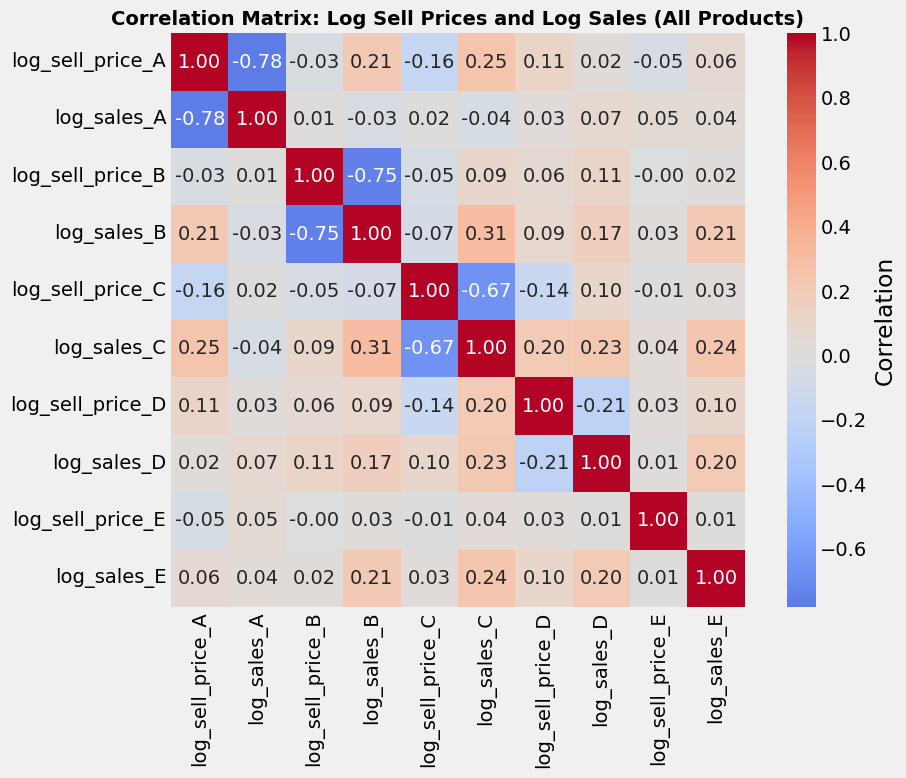

Log Sell Price and Log Sales Correlations:
                  log_sell_price_A  log_sales_A  log_sell_price_B  \
log_sell_price_A              1.00        -0.78             -0.03   
log_sales_A                  -0.78         1.00              0.01   
log_sell_price_B             -0.03         0.01              1.00   
log_sales_B                   0.21        -0.03             -0.75   
log_sell_price_C             -0.16         0.02             -0.05   
log_sales_C                   0.25        -0.04              0.09   
log_sell_price_D              0.11         0.03              0.06   
log_sales_D                   0.02         0.07              0.11   
log_sell_price_E             -0.05         0.05             -0.00   
log_sales_E                   0.06         0.04              0.02   

                  log_sales_B  log_sell_price_C  log_sales_C  \
log_sell_price_A         0.21             -0.16         0.25   
log_sales_A             -0.03              0.02        -0.04   
log_s

In [18]:
# Correlation plot of log_sell_price and log_sales for all products
corr_cols = [col for col in df_merge.columns if ('log_sell_price' in col) or ('log_sales' in col)]
price_corr = df_merge[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(price_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Matrix: Log Sell Prices and Log Sales (All Products)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('Log Sell Price and Log Sales Correlations:')
print(price_corr.round(2))

In [19]:
price_corr

,log_sell_price_A,log_sales_A,log_sell_price_B,log_sales_B,log_sell_price_C,log_sales_C,log_sell_price_D,log_sales_D,log_sell_price_E,log_sales_E
log_sell_price_A,1.000000,-0.780376,-0.030629,0.213823,-0.162891,0.254518,0.114798,0.023620,-0.048331,0.059905
log_sales_A,-0.780376,1.000000,0.013139,-0.031559,0.018927,-0.044591,0.028340,0.065996,0.049113,0.041093
log_sell_price_B,-0.030629,0.013139,1.000000,-0.749034,-0.049667,0.094374,0.058364,0.109912,-0.001977,0.019688
log_sales_B,0.213823,-0.031559,-0.749034,1.000000,-0.066416,0.310380,0.087742,0.169347,0.026090,0.212840
log_sell_price_C,-0.162891,0.018927,-0.049667,-0.066416,1.000000,-0.667997,-0.141009,0.095340,-0.011070,0.029052
log_sales_C,0.254518,-0.044591,0.094374,0.310380,-0.667997,1.000000,0.204369,0.225870,0.036342,0.238267
log_sell_price_D,0.114798,0.028340,0.058364,0.087742,-0.141009,0.204369,1.000000,-0.210134,0.030380,0.095408
log_sales_D,0.023620,0.065996,0.109912,0.169347,0.095340,0.225870,-0.210134,1.000000,0.012338,0.204952
log_sell_price_E,-0.048331,0.049113,-0.001977,0.026090,-0.011070,0.036342,0.030380,0.012338,1.000000,0.009996
log_sales_E,0.059905,0.041093,0.019688,0.212840,0.029052,0.238267,0.095408,0.204952,0.009996,1.000000


# OLS

In [ ]:
def linear_regression_statsmodels(fdf, product ='A',other_products_flag = False  ,temporal_columns_flag=False):
    """
    Perform OLS regression using statsmodels to predict log_sales_{product} from df_model.
    """
    temporal_col_names = [ 'dayofmonth', 'month', 'year','is_weekend'] #'dayofweek',
    # 'dayofyear' and 'month' are correlated - exclude 'dayofyear'
    col_name_product = [f'log_sales_{product}']
    col_name_product_price = [f'log_sell_price_{product}']
    col_names_price = [ 'log_sell_price_A','log_sell_price_B','log_sell_price_C','log_sell_price_D','log_sell_price_E']
    if other_products_flag == False:
        col_names_price = col_name_product_price
    if temporal_columns_flag == False:
        temporal_col_names = []
    df_model = fdf[col_name_product+col_names_price+temporal_col_names].copy(deep=True)
    print(f"Running OLS regression for product: {product}")
    print("-"*70)
    print(df_model.columns.tolist())
    # Use df_model
    df_work = df_model.copy(deep=True)

    target = f'log_sales_{product}'
    if target not in df_work.columns:
        raise KeyError(f"{target} not found in df_model columns: {df_work.columns.tolist()}")

    # Select numeric features (exclude target)
    X = df_work.select_dtypes(include=["number"]).drop(columns=[target], errors='ignore')
    y = df_work[target]

    # Drop rows with NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X = X.loc[mask]
    y = y.loc[mask]

    # Remove constant columns
    X = X.loc[:, X.std() > 0]

    print(f"Target: {target}")
    print(f"Number of observations: {len(y)}")
    print(f"Features ({len(X.columns)}): {X.columns.tolist()}")

    # Fit OLS
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm)
    results = model.fit()
    beta0, beta1 = results.params[0], results.params[1]

    print("\n" + "="*70)
    print("STATSMODELS OLS REGRESSION SUMMARY")
    print("="*70)
    print(results.summary())

    # Store results
    _sm_ols_results = results
    
    return _sm_ols_results, beta0, beta1


In [ ]:
lr_results = linear_regression_statsmodels(df_merge, product ='A')


We have used **power-law demand function:**
$$ ln(q) = \beta_0 + \beta_1 ln(p) $$
$$ q(p) = e^{\beta_0} e^{\beta_1 ln(p)} = e^{\beta_0} e^{ln(p^{\beta_1})} = e^{\beta_0} p^{\beta1} $$
$$R(p) = p \times q(p) = e^{\beta_0} \times p^{\beta_1 + 1}$$
Using FOC (to maximize revenue):
$$\frac{dR}{dp} = 0 \implies \frac{e^{\beta_0} \times p^{\beta_1 + 1}}{dp} = 0$$
$$\implies \beta_1 = -1$$



In [ ]:
data = df_merge[['sell_price_A','sales_A','log_sales_A','log_sell_price_A']].copy(deep=True)
data = data.rename(
    columns={
        'sell_price_A':'price','sales_A':'sales',
        'log_sell_price_A':'ln_price','log_sales_A':'ln_sales'
        }
    )
print(data.shape)
data = data.dropna()
print(data.shape)
# Fit log–log regression
X = sm.add_constant(data['ln_price'])
model = sm.OLS(data['ln_sales'], X).fit()
beta0, beta1 = model.params

print("Regression coefficients:")
print(f"β0 = {beta0:.4f}, β1 = {beta1:.4f}")


In [ ]:
# Demand function
def demand(p):
    return np.exp(beta0) * p**beta1

# Revenue function
def revenue(p):
    return p * demand(p)


In [ ]:
# We maximize revenue numerically within a sensible range
res = minimize_scalar(lambda p: -revenue(p),
                      bounds=(min(data['price']), max(data['price'])*5),
                      method='bounded')

optimal_price = res.x
max_revenue = revenue(optimal_price)

print(f"Optimal price: {optimal_price:.2f}")
print(f"Max revenue: {max_revenue:.2f}")
print(f"Sales: {max_revenue/optimal_price:.2f}")

In [ ]:
linear_regression_statsmodels(df_merge, product ='B')

In [ ]:
linear_regression_statsmodels(df_merge, product ='C')

In [ ]:
linear_regression_statsmodels(df_merge, product ='D')

In [ ]:
linear_regression_statsmodels(df_merge, product ='E')

In [ ]:
# # Clean regression workflow: impute, scale, Lasso feature selection, sklearn LR, and statsmodels OLS
# # Requires: scikit-learn, statsmodels (already installed)
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LassoCV, LinearRegression
# from sklearn.feature_selection import SelectFromModel
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score
# import statsmodels.api as sm

# # Use merged dataframe
# df_work = df_model.copy()

# target = 'log_sales_A'
# if target not in df_work.columns:
#     raise KeyError(f"{target} not found in df_merge columns: {df_work.columns.tolist()}")

# # Select numeric features (exclude target)
# X_raw = df_work.select_dtypes(include=["number"]).drop(columns=[target], errors='ignore')
# y = df_work[target]

# # Align and drop rows where target is missing
# mask = y.notna()
# X_raw = X_raw.loc[mask]
# y = y.loc[mask]

# # Impute median for numeric features
# imp = SimpleImputer(strategy='median')
# X_imp = pd.DataFrame(imp.fit_transform(X_raw), index=X_raw.index, columns=X_raw.columns)

# # Remove constant columns
# stds = X_imp.std()
# non_const_cols = stds[stds > 0].index.tolist()
# X_imp = X_imp[non_const_cols]

# # Scale
# scaler = StandardScaler()
# X_scaled = pd.DataFrame(scaler.fit_transform(X_imp), index=X_imp.index, columns=X_imp.columns)

# # LassoCV for feature selection (use default 5-fold CV)
# lasso = LassoCV(n_alphas=100, cv=5, random_state=42, max_iter=5000)
# lasso.fit(X_scaled, y.loc[X_scaled.index])
# selector = SelectFromModel(lasso, prefit=True, threshold='median')
# selected_mask = selector.get_support()
# selected_features = X_scaled.columns[selected_mask].tolist()

# print('Selected features ({}):'.format(len(selected_features)))
# print(selected_features)

# if len(selected_features) == 0:
#     print('No features selected by Lasso; using top 10 by absolute coef')
#     coef_series = pd.Series(np.abs(lasso.coef_), index=X_scaled.columns)
#     selected_features = list(coef_series.sort_values(ascending=False).head(10).index)

# X_sel = X_scaled[selected_features]

# # Train/test evaluation with sklearn LinearRegression
# X_train, X_test, y_train, y_test = train_test_split(X_sel, y.loc[X_sel.index], test_size=0.2, random_state=42)
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_pred = lr.predict(X_test)
# print('\nSklearn LinearRegression R^2 on test set:', r2_score(y_test, y_pred))

# # Show top coefficients
# coefs = pd.Series(lr.coef_, index=selected_features)
# print('\nTop coefficients (sklearn LR):')
# print(coefs.sort_values(key=lambda s: s.abs(), ascending=False).head(20))

# # Statsmodels OLS on selected features (full data without scaling inverse is fine for inference here)
# # Rebuild X for statsmodels using original (imputed but not scaled) values for interpretability
# X_sm = X_imp[selected_features]
# X_sm = sm.add_constant(X_sm)
# model = sm.OLS(y.loc[X_sm.index], X_sm)
# results = model.fit()
# print('\nOLS summary:')
# print(results.summary())

# # Store results objects for later inspection
# _regression_results = {
#     'selected_features': selected_features,
#     'sklearn_lr': lr,
#     'lasso_model': lasso,
#     'statsmodels_results': results
# }


In [ ]:

def plot_price_sales(fdf, product_name):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    print("Here")

    # Plot sales over time
    axes[0].plot(fdf.index, fdf[f'log_sales_{product_name}'], marker='o', linestyle='-', linewidth=2)
    axes[0].set_title(f'{product_name} - Log Sales Over Time', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Log Sales')
    axes[0].grid(True, alpha=0.3)

    # Plot sell_price over time
    axes[1].plot(fdf.index, fdf[f'log_sell_price_{product_name}'], marker='s', linestyle='-', linewidth=2, color='orange')
    axes[1].set_title(f'{product_name} - Log Sell Price Over Time', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Log Sell Price')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [ ]:
plot_price_sales(df_merge, 'A')
# plot_price_sales(df_merge, 'B')
# plot_price_sales(df_merge, 'C')
# plot_price_sales(df_merge, 'D')
plot_price_sales(df_merge, 'E')

In [ ]:
def plot_price_sales_correlation(df_product, product_name):
    # Correlation plot between sell_price and sales
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.scatter(df_product['log_price'], df_product['log_sales'], alpha=0.6, s=50, color='steelblue')
    ax.set_xlabel('Log Sell Price', fontsize=12, fontweight='bold')
    ax.set_ylabel('Log Sales', fontsize=12, fontweight='bold')
    ax.set_title(f'{product_name} - Correlation between Log Sell Price and Log Sales', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Add correlation coefficient
    corr = df_product['log_price'].corr(df_product['log_sales'])
    ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes, 
            fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

# plot_price_sales_correlation(df_product_A, 'Product A')
# plot_price_sales_correlation(df_product_B, 'Product B')
# plot_price_sales_correlation(df_product_C, 'Product C')
# plot_price_sales_correlation(df_product_D, 'Product D')
plot_price_sales_correlation(df_product_E, 'Product E')

In [ ]:
# # Day-wise boxplot of sales
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# axes = axes.flatten()

# products = [df_product_A, df_product_B, df_product_C, df_product_D, df_product_E]
# product_names = ['Product A', 'Product B', 'Product C', 'Product D', 'Product E']
# days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# for idx, (df_product, product_name) in enumerate(zip(products, product_names)):
#     # Prepare data for boxplot
#     data_by_day = [df_product[df_product['dayofweek'] == day]['sales'].values for day in range(7)]
    
#     bp = axes[idx].boxplot(data_by_day, labels=days, patch_artist=True)
    
#     # Color the boxes
#     for patch in bp['boxes']:
#         patch.set_facecolor('lightblue')
    
#     axes[idx].set_title(f'{product_name} - Day-wise Sales Distribution', fontsize=11, fontweight='bold')
#     axes[idx].set_xlabel('Day of Week')
#     axes[idx].set_ylabel('Sales')
#     axes[idx].grid(True, alpha=0.3, axis='y')

# # Hide the extra subplot
# axes[5].set_visible(False)

# plt.tight_layout()
# plt.show()


In [ ]:
# # Day-wise boxplot of sell_price
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# axes = axes.flatten()

# products = [df_product_A, df_product_B, df_product_C, df_product_D, df_product_E]
# product_names = ['Product A', 'Product B', 'Product C', 'Product D', 'Product E']
# days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# for idx, (df_product, product_name) in enumerate(zip(products, product_names)):
#     # Prepare data for boxplot
#     data_by_day = [df_product[df_product['dayofweek'] == day]['sell_price'].values for day in range(7)]
    
#     bp = axes[idx].boxplot(data_by_day, labels=days, patch_artist=True)
    
#     # Color the boxes
#     for patch in bp['boxes']:
#         patch.set_facecolor('lightcoral')
    
#     axes[idx].set_title(f'{product_name} - Day-wise Price Distribution', fontsize=11, fontweight='bold')
#     axes[idx].set_xlabel('Day of Week')
#     axes[idx].set_ylabel('Sell Price')
#     axes[idx].grid(True, alpha=0.3, axis='y')

# # Hide the extra subplot
# axes[5].set_visible(False)

# plt.tight_layout()
# plt.show()


In [ ]:
# # Requirements: statsmodels, scikit-learn
# # pip install statsmodels scikit-learn

# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score

# # Replace with your merged dataframe variable if different
# df_work = df_merge.copy()

# target = 'log_sales_A'   # dependent variable
# if target not in df_work.columns:
#     raise KeyError(f"{target} not found in dataframe columns: {df_work.columns.tolist()}")

# # Build X: numeric columns except the target
# X = df_work.select_dtypes(include=[np.number]).drop(columns=[target], errors='ignore')
# y = df_work[target]

# # Drop rows with NaNs in X or y
# mask = X.notna().all(axis=1) & y.notna()
# X = X.loc[mask]
# y = y.loc[mask]

# # (Optional) remove perfectly collinear or constant columns
# X = X.loc[:, X.std() > 0]

# # --- OLS (statsmodels) ---
# X_sm = sm.add_constant(X)         # adds intercept term
# model = sm.OLS(y, X_sm)
# results = model.fit()
# print("OLS summary:")
# print(results.summary())

# # --- Train/test linear regression (scikit-learn) ---
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_pred = lr.predict(X_test)
# print("\nSklearn LinearRegression R^2 on test set:", r2_score(y_test, y_pred))

# # Show coefficients (aligned to feature names)
# coefs = pd.Series(lr.coef_, index=X.columns)
# print("\nCoefficients (sklearn LR):")
# print(coefs.sort_values(ascending=False).head(20))

In [ ]:
# # Compact regression summary, save full OLS to file, and run CV (R^2 and MAE)
# from pathlib import Path
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer, mean_absolute_error
# import numpy as np

# out_dir = Path('results')
# out_dir.mkdir(exist_ok=True)
# summary_path = out_dir / 'regression_summary.txt'

# # Retrieve stored results
# res = globals().get('_regression_results', None)
# if res is None:
#     raise RuntimeError("_regression_results not found. Run the regression cell first.")

# selected_features = res.get('selected_features', [])
# lr = res.get('sklearn_lr')
# lasso = res.get('lasso_model')
# sm_res = res.get('statsmodels_results')

# # Compact print
# print('Selected features ({}):'.format(len(selected_features)))
# print(selected_features)

# # Top coefficients from sklearn LR
# if lr is not None:
#     coefs = pd.Series(lr.coef_, index=selected_features)
#     print('\nTop coefficients (sklearn LR):')
#     print(coefs.sort_values(key=lambda s: s.abs(), ascending=False).head(10))
# else:
#     print('\nNo sklearn LR model found in _regression_results')

# # Test R^2: try to compute if test split stored (not stored). We'll recompute a quick train/test split for a compact R^2.
# try:
#     X_imp = globals().get('X_imp')
#     y = globals().get('y')
#     if X_imp is None or y is None:
#         # try to rebuild minimal X_imp,y from df_merge
#         df_work = globals().get('df_merge')
#         if df_work is None:
#             raise RuntimeError('df_merge not found for recomputing test R^2')
#         # use selected features from df_merge (impute median)
#         X_temp = df_work[selected_features].copy()
#         X_temp = X_temp.fillna(X_temp.median())
#         y_temp = df_work['log_sales_A'].loc[X_temp.index]
#     else:
#         X_temp = X_imp[selected_features].copy()
#         y_temp = y.loc[X_temp.index]

#     from sklearn.model_selection import train_test_split
#     X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
#     lr_tmp = LinearRegression()
#     lr_tmp.fit(X_train, y_train)
#     y_pred = lr_tmp.predict(X_test)
#     test_r2 = r2_score(y_test, y_pred)
#     print(f"\nCompact test R^2 (recomputed): {test_r2:.4f}")
# except Exception as e:
#     print('\nCould not recompute compact test R^2:', e)

# # Cross-validated scores
# try:
#     X_cv = X_temp
#     y_cv = y_temp
#     # R^2 CV
#     cv_r2 = cross_val_score(LinearRegression(), X_cv, y_cv, cv=5, scoring='r2')
#     # MAE CV (negative MAE returned by scikit-learn with scoring that expects higher is better)
#     neg_mae = cross_val_score(LinearRegression(), X_cv, y_cv, cv=5, scoring='neg_mean_absolute_error')
#     cv_mae = -neg_mae
#     print(f"\nCV R^2 (5-fold): mean={cv_r2.mean():.4f}, std={cv_r2.std():.4f}")
#     print(f"CV MAE (5-fold): mean={cv_mae.mean():.4f}, std={cv_mae.std():.4f}")
# except Exception as e:
#     print('\nCV evaluation failed:', e)

# # Save full OLS summary to file
# try:
#     with open(summary_path, 'w') as f:
#         f.write('Selected features:\n')
#         f.write('\n'.join(selected_features) + '\n\n')
#         f.write('Sklearn coefficients (top 50):\n')
#         if lr is not None:
#             coef_lines = coefs.sort_values(key=lambda s: s.abs(), ascending=False).head(50).to_string()
#             f.write(coef_lines + '\n\n')
#         f.write('Statsmodels OLS summary:\n')
#         if sm_res is not None:
#             f.write(str(sm_res.summary()) + '\n')
#         else:
#             f.write('No statsmodels results found')
#     print(f"\nFull OLS summary saved to {summary_path}")
# except Exception as e:
#     print('\nFailed to write summary file:', e)


In [ ]:
# # Multicollinearity check: correlation pairs, VIF, and condition number
# from pathlib import Path
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import numpy as np
# import pandas as pd

# product = 'A'
# temporal_col_names =['dayofweek', 'dayofmonth','dayofyear', 'month', 'year','is_weekend']
# col_name_product = [f'log_sales_{product}']
# col_names_price = [ 'log_sell_price_A','log_sell_price_B','log_sell_price_C','log_sell_price_D','log_sell_price_E']
# df_model = df_merge[col_name_product+col_names_price+temporal_col_names].copy(deep=True)
# out_dir = Path('results')
# out_dir.mkdir(exist_ok=True)

# # Choose working dataframe: df_model (as built earlier)
# df_work = globals().get('df_model', None)
# if df_work is None:
#     raise RuntimeError('df_model not found in notebook namespace')

# # target may be log_sales_A — exclude target from features
# target = f'log_sales_{product}'
# if target in df_work.columns:
#     X = df_work.drop(columns=[target])
# else:
#     X = df_work.copy()

# # Keep numeric columns only
# X_num = X.select_dtypes(include=[np.number]).copy()
# if X_num.shape[1] == 0:
#     raise RuntimeError('No numeric features found to compute multicollinearity')

# # Impute median for any missing values to allow VIF computation
# imp = SimpleImputer(strategy='median')
# X_imp = pd.DataFrame(imp.fit_transform(X_num), index=X_num.index, columns=X_num.columns)

# # Compute correlation matrix and list high-correlation pairs
# corr = X_imp.corr()
# threshold = 0.8
# high_pairs = []
# cols = X_imp.columns.tolist()
# for i in range(len(cols)):
#     for j in range(i+1, len(cols)):
#         v = corr.iloc[i, j]
#         if abs(v) >= threshold:
#             high_pairs.append((cols[i], cols[j], float(v)))

# # Save correlation matrix and high pairs
# corr.to_csv(out_dir / 'correlation_matrix.csv')
# with open(out_dir / 'high_corr_pairs.txt', 'w') as f:
#     f.write(f'Pairs with |corr| >= {threshold}\n')
#     for a,b,v in high_pairs:
#         f.write(f'{a}\t{b}\t{v:.4f}\n')

# # Prepare X for VIF: add constant not needed for VIF calculation
# # Remove constant / zero-variance columns
# stds = X_imp.std()
# non_const = stds[stds > 0].index.tolist()
# X_vif = X_imp[non_const]

# # Standardize before computing condition number
# scaler = StandardScaler()
# X_scaled = pd.DataFrame(scaler.fit_transform(X_vif), index=X_vif.index, columns=X_vif.columns)

# # Compute VIFs
# vifs = []
# for i, col in enumerate(X_vif.columns):
#     try:
#         vif_val = variance_inflation_factor(X_vif.values, i)
#     except Exception as e:
#         vif_val = np.nan
#     vifs.append((col, float(vif_val)))

# vif_df = pd.DataFrame(vifs, columns=['feature', 'VIF']).sort_values('VIF', ascending=False)
# vif_df.to_csv(out_dir / 'vif.csv', index=False)

# # Condition number (of X'X)
# cond_number = np.linalg.cond(X_scaled)

# # Compact printout
# print('Multicollinearity check — compact summary')
# print('-'*60)
# print(f'Number of numeric features: {X_num.shape[1]}')
# print(f'High-correlation pairs (|corr| >= {threshold}): {len(high_pairs)}')
# for a,b,v in high_pairs[:10]:
#     print(f'  {a} — {b}: {v:.3f}')
# if len(high_pairs) > 10:
#     print(f'  ... and {len(high_pairs)-10} more')

# print('\nTop VIFs:')
# print(vif_df.head(10).to_string(index=False))
# print(f'\nCondition number (scaled X): {cond_number:.3f}')
# print('\nSaved:')
# print(f' - correlation matrix -> {out_dir / "correlation_matrix.csv"}')
# print(f' - high correlation pairs -> {out_dir / "high_corr_pairs.txt"}')
# print(f' - VIFs -> {out_dir / "vif.csv"}')

# # Expose variables for later inspection
# _vif_df = vif_df
# _high_corr_pairs = high_pairs
# _cond_number = cond_number
# _corr_matrix = corr


In [ ]:
# Density plot for df_merge['log_sell_price_E']
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure column exists and drop NA values
col = 'log_sell_price_E'
if col not in df_merge.columns:
    raise KeyError(f"{col} not found in df_merge columns: {df_merge.columns.tolist()}")

data = df_merge[col].dropna()
if data.shape[0] == 0:
    print(f'No non-null values found for {col}')
else:
    plt.figure(figsize=(8,5))
    sns.kdeplot(data, fill=True, bw_method='scott', color='C0')
    plt.title('Density plot: log_sell_price_E', fontsize=14, fontweight='bold')
    plt.xlabel('log_sell_price_E')
    plt.ylabel('Density')
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

# Product E

In [ ]:
df_product_E.dropna(inplace=True)
df_product_E['revenue_E'] = df_product_E['sell_price_E'] * df_product_E['sales_E']
df_product_E

In [ ]:
mode_E = df_product_E['log_sell_price_E'].mode()
print(type(mode_E))
print(mode_E.iloc[0] )
df_product_E['flag_discount_E'] = np.where(
    df_product_E['log_sell_price_E'] < mode_E.iloc[0]*0.98, 1, 0
)
df_product_E['percentage_discount_E'] =  (mode_E.iloc[0] - df_product_E['log_sell_price_E']) / mode_E.iloc[0] * 100
df_product_E['percentage_discount_E'].value_counts()

In [ ]:

# Create continuous week column for df_product_E (based on elapsed time from earliest date)
min_date = df_product_E.index.min()
df_product_E['week'] = np.ceil((df_product_E.index - min_date).days / 7).astype(int)
# Ensure week starts at 1 (not 0)
df_product_E['week'] = df_product_E['week'] + 1
print(f"Week column created. Min date: {min_date}, Unique weeks: {sorted(df_product_E['week'].unique())}")
# print(df_product_E[['week']].head(15))

In [ ]:
df_product_E

In [ ]:
col_names = ['sell_price_E','sales_E','log_sales_E','log_sell_price_E','flag_discount_E','week']
data = df_product_E[col_names].copy(deep=True)
data = data.rename(
    columns={
        'sell_price_E':'price','sales_E':'sales',
        'log_sell_price_E':'ln_price','log_sales_E':'ln_sales'
        }
    )
print(data.shape)
data = data.dropna()
print(data.shape)
# Fit log–log regression
X = sm.add_constant(data['week'])
model = sm.OLS(data['ln_sales'], X).fit()
beta0, beta1 = model.params

print("Regression coefficients:")
print(f"β0 = {beta0:.4f}, β1 = {beta1:.4f}")


In [ ]:
data['is_weekend'] = (data['dayofweek'] >= 5).astype(int)

In [ ]:
def linear_regression_statsmodels(fdf, target_column_name, independent_variables_columns):
    """
    Perform OLS regression using statsmodels to predict log_sales_{product} from df_model.
    """
    df_model = fdf[[target_column_name] + independent_variables_columns].copy(deep=True)
    print(df_model.columns )
    print("-"*70)
    print(df_model.columns.tolist())
    # Use df_model
    df_work = df_model.copy(deep=True)

    target = target_column_name
    if target not in df_work.columns:
        raise KeyError(f"{target} not found in df_model columns: {df_work.columns.tolist()}")

    # Select numeric features (exclude target)
    X = df_work.select_dtypes(include=["number"]).drop(columns=[target], errors='ignore')
    y = df_work[target]

    # Drop rows with NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X = X.loc[mask]
    y = y.loc[mask]

    # Remove constant columns
    X = X.loc[:, X.std() > 0]

    print(f"Target: {target}")
    print(f"Number of observations: {len(y)}")
    print(f"Features ({len(X.columns)}): {X.columns.tolist()}")

    # Fit OLS
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm)
    results = model.fit()
    beta0, beta1 = results.params[0], results.params[1]

    print("\n" + "="*70)
    print("STATSMODELS OLS REGRESSION SUMMARY")
    print("="*70)
    print(results.summary())

    # Store results
    _sm_ols_results = results
    
    return _sm_ols_results, beta0, beta1


In [ ]:
independent_variables_columns = ['week','percentage_discount_E']
target_column_name = 'log_sales_E'
linear_regression_statsmodels(df_product_E, target_column_name, independent_variables_columns)

In [ ]:
independent_variables_columns = ['week','flag_discount_E']
target_column_name = 'log_sales_E'
linear_regression_statsmodels(df_product_E, target_column_name, independent_variables_columns)

In [ ]:
independent_variables_columns = ['week','log_sell_price_E']
target_column_name = 'log_sales_E'
linear_regression_statsmodels(df_product_E, target_column_name, independent_variables_columns)

In [ ]:
df_product_E.groupby('week')['sales_E'].sum().plot()

In [ ]:
df_product_E.groupby('week')['sell_price_E'].mean().plot()

In [ ]:
df_product_A['sell_price_A'].plot()